In [8]:
"""# ⚙️ Preprocessing & Feature Engineering

This notebook extracts and engineers features from both **flow-level** and **packet-level** data.

### Objectives:
1. Parse raw datasets (`flows.csv`, `packets.pcap`)  
2. Perform header & payload feature extraction  
3. Apply normalization and dimensionality reduction (PCA)  
4. Save processed datasets for modeling  

**Outputs:**
- `/data/features/flow_features.pkl`
- `/data/features/packet_features.npy`
- `/data/features/feature_metadata.json`
"""

'# ⚙️ Preprocessing & Feature Engineering\n\nThis notebook extracts and engineers features from both **flow-level** and **packet-level** data.\n\n### Objectives:\n1. Parse raw datasets (`flows.csv`, `packets.pcap`)  \n2. Perform header & payload feature extraction  \n3. Apply normalization and dimensionality reduction (PCA)  \n4. Save processed datasets for modeling  \n\n**Outputs:**\n- `/data/features/flow_features.pkl`\n- `/data/features/packet_features.npy`\n- `/data/features/feature_metadata.json`\n'

In [10]:
"""## 🔁 Inputs & Outputs

| Type | Input | Output |
|------|--------|---------|
| Flow | `data/sample/flows.csv` | `data/features/flow_features.pkl` |
| Packet | `data/sample/packets.pcap` | `data/features/packet_features.npy` |
| Metadata | `data/sample/dataset_summary.json` | `data/features/feature_metadata.json` |
"""

'## 🔁 Inputs & Outputs\n\n| Type | Input | Output |\n|------|--------|---------|\n| Flow | `data/sample/flows.csv` | `data/features/flow_features.pkl` |\n| Packet | `data/sample/packets.pcap` | `data/features/packet_features.npy` |\n| Metadata | `data/sample/dataset_summary.json` | `data/features/feature_metadata.json` |\n'

In [11]:
import os, json, numpy as np, pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.feature_extraction import FeatureHasher
from tqdm import tqdm

from scapy.all import rdpcap, IP, TCP, UDP, Raw

# Create feature folder
Path("data/features").mkdir(parents=True, exist_ok=True)
print("✅ Feature directory ready: data/features/")


✅ Feature directory ready: data/features/


In [12]:
flow_path = "data/sample/flows.csv"
if os.path.exists(flow_path):
    df_flows = pd.read_csv(flow_path)
    print("Flow data loaded:", df_flows.shape)
    display(df_flows.head())
else:
    raise FileNotFoundError("⚠️ flows.csv not found. Run 01_data_acquisition_and_sampling first.")


Flow data loaded: (50, 6)


,flow_id,src_ip,dst_ip,pkt_count,avg_pkt_size,label
0,0,192.168.0.0,10.0.0.0,20,60.0,attack
1,1,192.168.0.1,10.0.0.2,20,55.0,normal
2,2,192.168.0.2,10.0.0.4,20,55.0,normal
3,3,192.168.0.3,10.0.0.6,20,55.0,normal
4,4,192.168.0.4,10.0.0.8,20,55.0,normal


In [13]:
# 🧹 Clean NaNs, standardize column names
df_flows.columns = [c.strip().lower().replace('-', '_') for c in df_flows.columns]
df_flows = df_flows.fillna(0)

# Label encoding if 'label' present
if "label" in df_flows.columns:
    df_flows["label_encoded"] = df_flows["label"].astype("category").cat.codes

print("Unique labels:", df_flows["label"].unique() if "label" in df_flows.columns else "N/A")


Unique labels: ['attack' 'normal']


In [15]:
"""## 🧩 Header Feature Extraction
We’ll engineer header-level fields from flow data and PCAPs:
- IP-based fields (src/dst)
- Port numbers
- Protocols
- Packet count, byte count
- Average packet size, flags
"""

'## 🧩 Header Feature Extraction\nWe’ll engineer header-level fields from flow data and PCAPs:\n- IP-based fields (src/dst)\n- Port numbers\n- Protocols\n- Packet count, byte count\n- Average packet size, flags\n'

In [17]:
from sklearn.feature_extraction import FeatureHasher

fh = FeatureHasher(n_features=16, input_type='string')

# Wrap each IP string into a list
src_iter = [[ip] for ip in df_flows['src_ip'].astype(str)]
dst_iter = [[ip] for ip in df_flows['dst_ip'].astype(str)]

hashed_src = fh.transform(src_iter).toarray()
hashed_dst = fh.transform(dst_iter).toarray()
hashed_df = pd.DataFrame(
    np.hstack([hashed_src, hashed_dst]),
    columns=[f"h_{i}" for i in range(32)]
)
features = pd.concat([df_flows.select_dtypes(include=np.number), hashed_df], axis=1)
print("✅ Feature matrix shape:", features.shape)


✅ Feature matrix shape: (50, 36)


In [18]:
"""## 📦 Packet-Level Feature Extraction
We’ll parse `packets.pcap` to extract payload slices and header stats.
Each packet will yield:
- Length
- TTL
- Protocol (TCP/UDP)
- Payload bytes (first 128 bytes, padded)
"""

'## 📦 Packet-Level Feature Extraction\nWe’ll parse `packets.pcap` to extract payload slices and header stats.\nEach packet will yield:\n- Length\n- TTL\n- Protocol (TCP/UDP)\n- Payload bytes (first 128 bytes, padded)\n'

In [19]:
pcap_path = "data/sample/packets.pcap"

packet_features = []
if os.path.exists(pcap_path):
    packets = rdpcap(pcap_path)
    for pkt in tqdm(packets, desc="Parsing packets"):
        if IP in pkt:
            proto = "TCP" if TCP in pkt else "UDP" if UDP in pkt else "OTHER"
            payload = bytes(pkt[Raw].load[:128]) if Raw in pkt else b''
            payload_bytes = np.frombuffer(payload, dtype=np.uint8)
            # pad/truncate payload to fixed length
            if len(payload_bytes) < 128:
                payload_bytes = np.pad(payload_bytes, (0, 128 - len(payload_bytes)))
            else:
                payload_bytes = payload_bytes[:128]
            packet_features.append({
                "length": len(pkt),
                "ttl": pkt[IP].ttl,
                "protocol": proto,
                "payload_bytes": payload_bytes
            })
    print(f"Extracted {len(packet_features)} packets")
else:
    print("⚠️ No packets.pcap found — skipping packet features.")


Parsing packets: 100%|██████████| 1000/1000 [00:00<00:00, 10656.26it/s]


Extracted 1000 packets


In [20]:
if packet_features:
    packet_df = pd.DataFrame(packet_features)
    proto_map = {"TCP": 0, "UDP": 1, "OTHER": 2}
    packet_df["protocol_code"] = packet_df["protocol"].map(proto_map)
    payload_array = np.stack(packet_df["payload_bytes"].values)
    print("Payload feature array shape:", payload_array.shape)
else:
    packet_df, payload_array = pd.DataFrame(), np.empty((0,128))


Payload feature array shape: (1000, 128)


In [21]:
"""## ⚙️ Scaling & Dimensionality Reduction
We’ll normalize all numerical features and apply Incremental PCA (lightweight & memory-safe).
"""

'## ⚙️ Scaling & Dimensionality Reduction\nWe’ll normalize all numerical features and apply Incremental PCA (lightweight & memory-safe).\n'

In [22]:
scaler = StandardScaler()
flow_scaled = scaler.fit_transform(features)

# Apply incremental PCA for dimensionality reduction
pca = IncrementalPCA(n_components=10, batch_size=1000)
flow_pca = pca.fit_transform(flow_scaled)

print("Reduced flow feature shape:", flow_pca.shape)


Reduced flow feature shape: (50, 10)


In [23]:
import joblib

joblib.dump({
    "features": flow_pca,
    "labels": df_flows.get("label_encoded", None),
    "scaler": scaler,
    "pca": pca
}, "data/features/flow_features.pkl")

print("✅ Saved flow features → data/features/flow_features.pkl")


✅ Saved flow features → data/features/flow_features.pkl


In [24]:
np.save("data/features/packet_features.npy", payload_array)
print("✅ Saved packet feature array → data/features/packet_features.npy")


✅ Saved packet feature array → data/features/packet_features.npy


In [25]:
"""## 🧾 Feature Metadata
We store dataset summary, PCA variance, and reproducibility info in JSON format.
"""

'## 🧾 Feature Metadata\nWe store dataset summary, PCA variance, and reproducibility info in JSON format.\n'

In [26]:
meta = {
    "timestamp": pd.Timestamp.now().isoformat(),
    "flow_features_shape": flow_pca.shape,
    "packet_features_shape": payload_array.shape,
    "pca_explained_variance": list(np.round(pca.explained_variance_ratio_, 4)),
    "scaler_mean": list(np.round(scaler.mean_, 4)),
    "dataset_source": "synthetic" if "synthetic" in flow_path else "public_sample"
}

with open("data/features/feature_metadata.json", "w") as f:
    json.dump(meta, f, indent=4)

print("✅ Metadata saved → data/features/feature_metadata.json")


✅ Metadata saved → data/features/feature_metadata.json


In [27]:
"""## 📈 Optional Visualization
You can visualize PCA variance and feature distributions.
"""

'## 📈 Optional Visualization\nYou can visualize PCA variance and feature distributions.\n'

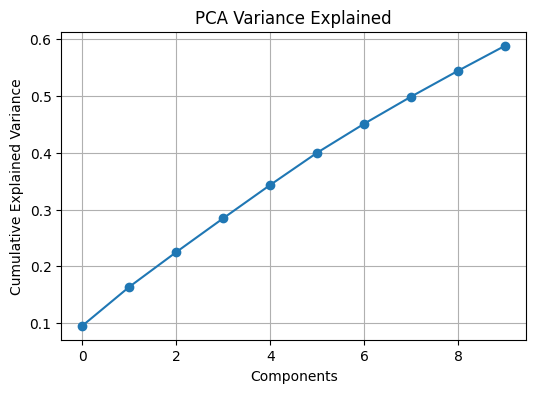

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Variance Explained")
plt.grid(True)
plt.show()


In [29]:
"""## 🏁 Notebook Summary

You have successfully:
- Parsed and cleaned flow and packet data  
- Extracted hashed header features and payload byte vectors  
- Applied normalization and PCA  
- Saved processed features and metadata  

**Next:**  
➡️ Proceed to [03_baseline_models_training.ipynb](03_baseline_models_training.ipynb)

**Artifacts Created:**
- `data/features/flow_features.pkl`
- `data/features/packet_features.npy`
- `data/features/feature_metadata.json`
"""

'## 🏁 Notebook Summary\n\nYou have successfully:\n- Parsed and cleaned flow and packet data  \n- Extracted hashed header features and payload byte vectors  \n- Applied normalization and PCA  \n- Saved processed features and metadata  \n\n**Next:**  \n➡️ Proceed to [03_baseline_models_training.ipynb](03_baseline_models_training.ipynb)\n\n**Artifacts Created:**\n- `data/features/flow_features.pkl`\n- `data/features/packet_features.npy`\n- `data/features/feature_metadata.json`\n'

In [30]:
print("✅ Feature engineering complete. Proceed to 03_baseline_models_training.ipynb.")


✅ Feature engineering complete. Proceed to 03_baseline_models_training.ipynb.
